# Proyecto IDS
## Integrantes:
- Vicente Alarcón
- Matías Fontecilla

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
path_file = 'games.csv'
columns = ['AppID', 'Name', 'Release date', 'Estimated owners', 'Price', 'Metacritic score', 'Positive', 'Negative']
df = pd.read_csv(path_file, usecols=columns)
df = df[df['Metacritic score'] > 0]

df['Steam score'] = ((df['Positive'] / (df['Positive'] + df['Negative'])) * 100).round()
df['Steam score'] = df['Steam score'].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int)

df = df.loc[df['Positive'] + df['Negative'] > 500]

df = df.sort_values(by=['Steam score', 'Metacritic score'], ascending=False)
print(len(df))
print(df.head())
df.to_csv('filtered_games.csv', index=False)

2580
         AppID                 Name  Release date     Estimated owners  Price  \
28170      620             Portal 2  Apr 18, 2011  10000000 - 20000000   9.99   
28484      659             Portal 2  Apr 18, 2011            0 - 20000   9.99   
25418  1145360                Hades  Sep 17, 2020   5000000 - 10000000  24.99   
12898    57400  Batman: Arkham City  Nov 15, 2011        20000 - 50000   0.00   
23749   324160              CLANNAD  Nov 23, 2015      100000 - 200000  44.99   

       Metacritic score  Positive  Negative  Steam score  
28170                95    298300      3638           99  
28484                95    153381      2059           99  
25418                93    190880      2662           99  
12898                91      1966        26           99  
23749                83      6076        86           99  


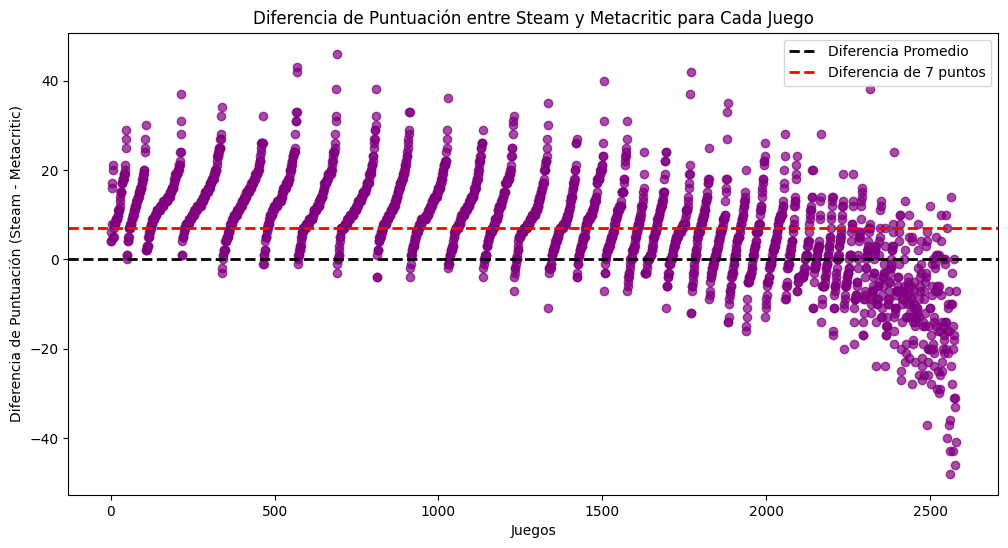

In [9]:
df = pd.read_csv('filtered_games.csv')
df = df[['AppID', 'Name', 'Metacritic score', 'Steam score']]
# Calcular la diferencia entre las puntuaciones
df['Diferencia'] = df['Steam score'] - df['Metacritic score']

# Calcular las medias
metacritic_mean = df['Metacritic score'].mean()
steam_mean = df['Steam score'].mean()

# Calcular la diferencia
diferencia = steam_mean - metacritic_mean

# Crear un gráfico de puntos
plt.figure(figsize=(12, 6))

# Dibujar los puntos
plt.scatter(df.index, df['Diferencia'], color='purple', alpha=0.7)

# Añadir líneas horizontales para resaltar la diferencia promedio
plt.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Diferencia Promedio')
plt.axhline(y=7, color='red', linestyle='--', linewidth=2, label='Diferencia de 7 puntos')

# Añadir etiquetas y título
plt.xlabel('Juegos')
plt.ylabel('Diferencia de Puntuación (Steam - Metacritic)')
plt.title('Diferencia de Puntuación entre Steam y Metacritic para Cada Juego')
plt.legend()

# Mostrar el gráfico
plt.show()

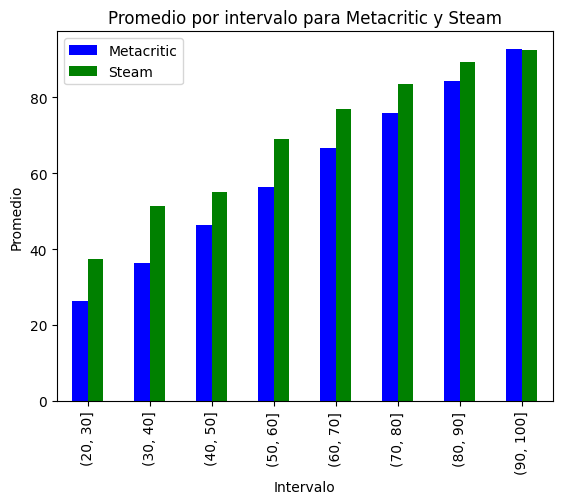

In [14]:
# Leer el archivo CSV
df = pd.read_csv('filtered_games.csv')

# Seleccionar las columnas relevantes
df = df[['AppID', 'Name', 'Metacritic score', 'Steam score']]

# Calcular el promedio de las puntuaciones

# Crear los intervalos
bins = range(0, 101, 10)

# Dividir los datos en intervalos
df['Intervalo'] = pd.cut(df['Metacritic score'], bins)

# Calcular el promedio para cada intervalo
promedio_por_intervalo_metacritic = df.groupby('Intervalo', observed=True)['Metacritic score'].mean()

# Calcular el promedio para cada intervalo
promedio_por_intervalo_steam = df.groupby('Intervalo', observed=True)['Steam score'].mean()

# print("Promedio por intervalo para Metacritic:")
# print(promedio_por_intervalo_metacritic)

# print("\nPromedio por intervalo para Steam:")
# print(promedio_por_intervalo_steam)

# Crear un DataFrame con los promedios por intervalo
df_promedios = pd.DataFrame({
    'Metacritic': promedio_por_intervalo_metacritic,
    'Steam': promedio_por_intervalo_steam
})

# Graficar los promedios en un solo gráfico de barras
df_promedios.plot.bar(color=['blue', 'green'])
plt.title('Promedio por intervalo para Metacritic y Steam')
plt.xlabel('Intervalo')
plt.ylabel('Promedio')
plt.show()